In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [64]:
with open('/datax/scratch/andresl/pipeline-runs/all-bands/full-run/logs/all_logs.log', 'r') as f:
    lines = pd.Series(f.readlines())

In [65]:
lines.iloc[-2]

'2025-08-03 00:00:19,504 | INFO | rfi_pipeline.filejob (blc27_guppi_59309_71052_HIP77002_0040.rawspec.0000.h5) (1552041): Finished file! Took 26.7s\n'

In [66]:
loading = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d+)\): Done (?P<which>loading) block, took (?P<time>[\d\.e\+\-]+)s\.\n'
)

fitting = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d*)\): Done (?P<which>fitting) Gaussians, took (?P<time>[e+\-\d\.]+)s\.\n'
)

threshold = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d*)\): Done (?P<which>threshold)-based estimation, took (?P<time>[e+\-\d\.]+)s\.\n'
)

hits = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d+)\): Done getting (?P<which>hits), took (?P<time>[\d+\-\.e]+)s\n'
)

filtering = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d+)\): Done (?P<which>filtering) blocks, took (?P<time>[\d\.e+\-]+)s\.\n'
)

file = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d+)\): Finished (?P<which>file)! Took (?P<time>[\d\.e+\-]+)s'
)

times = (loading
         .combine_first(fitting)
         .combine_first(threshold)
         .combine_first(hits)
         .combine_first(filtering)
         .combine_first(file)
         .dropna()
         .reset_index(drop=True)
         .reset_index())
times['time'] = times['time'].astype(float)

In [67]:
times.to_csv('/datax/scratch/andresl/pipeline-runs/all-bands/full-run/logs/times.csv', index=False)

<Axes: xlabel='time', ylabel='Density'>

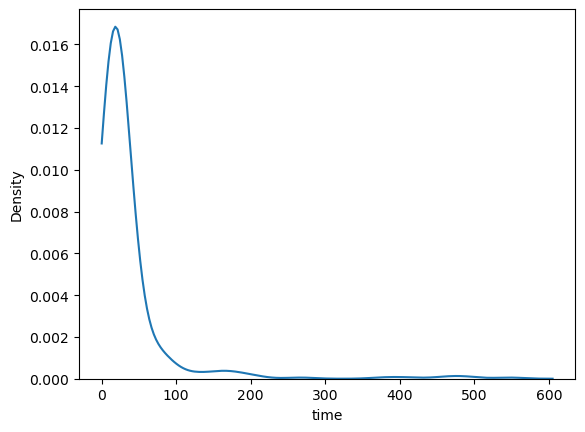

In [68]:
sns.kdeplot(times.loc[times['which'] == 'file', 'time'], clip=(0, None))

/tmp/ipykernel_1532228/2683312879.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


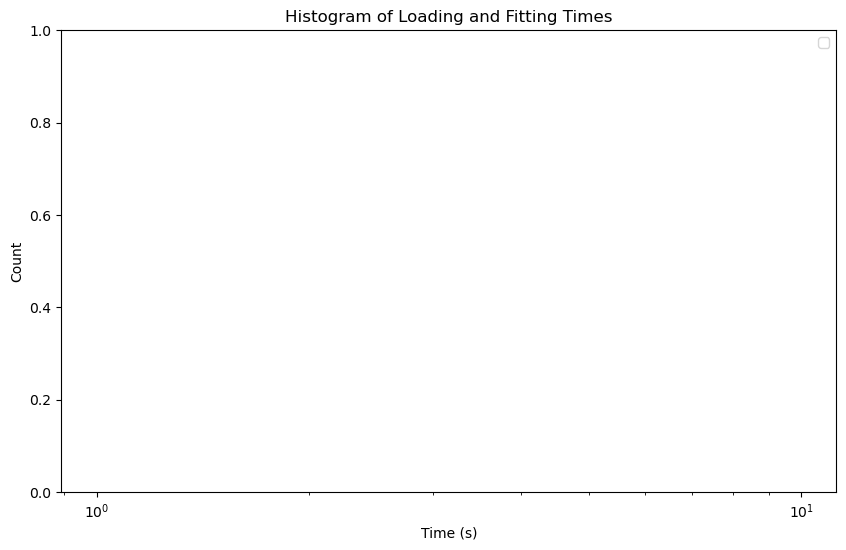

In [57]:
# Define log-spaced bins covering the range of all times
load_and_fit = times[times['which'].isin(['loading', 'threshold'])]
min_time = load_and_fit['time'].min()
max_time = load_and_fit['time'].max()
bins = np.logspace(np.log10(min_time), np.log10(max_time), 100)
# bins = 10**np.histogram_bin_edges(np.log10(load_and_fit['time']), bins='auto')

plt.figure(figsize=(10, 6))
# plt.hist(times[times['which'] == 'loading']['time'], bins=bins, alpha=0.7, label='loading', color='blue')
# plt.hist(times[times['which'] == 'threshold']['time'], bins=bins, alpha=0.7, label='threshold', color='orange')
sns.kdeplot(times[times['which'] == 'loading']['time'], label='loading', color='blue')
sns.kdeplot(times[times['which'] == 'threshold']['time'], label='loading', color='blue')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.title('Histogram of Loading and Fitting Times')
plt.legend()
plt.show()

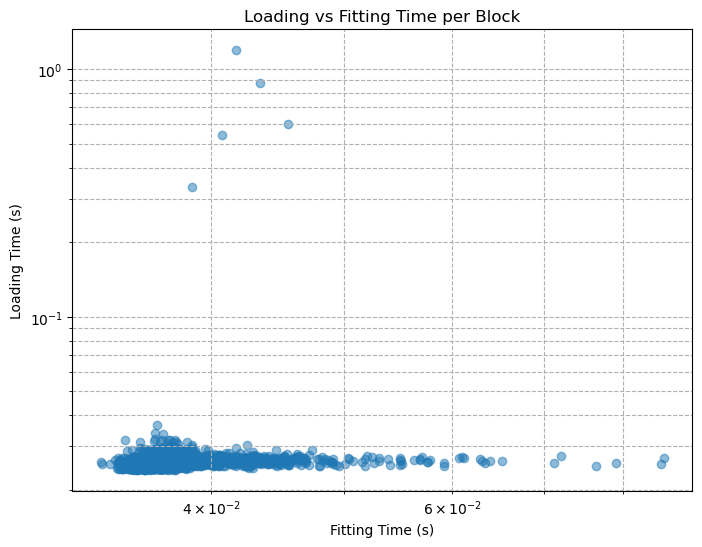

In [9]:
# Sort times by file and index to ensure adjacent rows correspond to the same block
times_sorted = times.sort_values(['file', 'index']).reset_index(drop=True)

# Find pairs of adjacent rows in 'times' where one is 'loading' and the next is 'fitting' for the same file and pid
pairs = []
for i in range(len(times_sorted) - 1):
    row1 = times_sorted.iloc[i]
    row2 = times_sorted.iloc[i + 1]
    # Only count "loading" followed by "fitting" for the same file and pid
    if (
        row1['file'] == row2['file']
        and row1['pid'] == row2['pid']
        and row1['which'] == 'loading'
        and row2['which'] == 'fitting'
    ):
        pairs.append((row1['time'], row2['time']))

# Convert to numpy arrays for plotting
loading_times = np.array([p[0] for p in pairs])
fitting_times = np.array([p[1] for p in pairs])

plt.figure(figsize=(8, 6))
plt.scatter(fitting_times, loading_times, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Fitting Time (s)')
plt.ylabel('Loading Time (s)')
plt.title('Loading vs Fitting Time per Block')
plt.grid(True, which="both", ls="--")
plt.show()

In [10]:
# Calculate the ratio of fitting time to loading time for each pair
ratios = [fit / load for load, fit in pairs if load > 0]

# Compute the average ratio
average_ratio = np.mean(ratios)
print(f"On average, fitting takes {average_ratio:.2f} times longer than loading.")

On average, fitting takes 1.46 times longer than loading.
